In [1]:
import json
data = list()
for filename in ['results/2020-01-18T00:30:29.422800-05:00.json',
                 'results/2020-01-18T12:37:03.836634-05:00.json']:
    with open(filename, 'r') as infile:
        data += json.load(infile)

In [2]:
EPS = 1e-9
for entry in data:
    entry['auc'] = sum(entry['accuracy'])
    if (entry['optimizer'] == 'sgd') and (abs(float(entry['momentum'])) > EPS):
        entry['optimizer'] = 'momentum'  # separate sgd with and without momentum

In [3]:
from tools import *
temp = dict()
for entry in data:
    key = get_hyperparameter_key(entry)
    if key in temp:
        temp[key].append(entry['auc'])
    else:
        temp[key] = [entry['auc']]
auc_table = list()
for key, value in temp.items():
    entry = dict(key._asdict())
    entry['auc_mean'] = np.mean(value)
    entry['auc_stderr'] = np.std(value) / np.sqrt(len(value))
    assert(len(value) == 60)
    auc_table.append(entry)
auc_table = pd.DataFrame(list_of_dicts_to_dict_of_lists(auc_table))
auc_table.head(n=10)

,beta_1,beta_2,lr,momentum,optimizer,rho,auc_mean,auc_stderr
0,NaN,NaN,0.001000,NaN,rms,0.9,30606.374387,8.405563
1,NaN,NaN,0.000100,NaN,rms,0.9,30355.083572,21.014562
2,NaN,NaN,0.010000,0.0,sgd,NaN,27909.072555,14.528597
3,NaN,NaN,0.000100,0.0,sgd,NaN,28461.906492,14.806430
4,NaN,NaN,0.010000,0.9,momentum,NaN,39018.999907,8.554028
5,NaN,NaN,0.000001,0.9,momentum,NaN,26734.011406,15.852787
6,NaN,NaN,0.000010,NaN,rms,0.9,38849.153072,51.506193
7,0.9,0.999,0.001000,NaN,adam,NaN,28728.564599,31.702995
8,NaN,NaN,0.000010,0.0,sgd,NaN,26719.303126,15.937798
9,0.9,0.999,0.010000,NaN,adam,NaN,29565.822266,74.346698


In [4]:
best_auc_table = list()
for optimizer in auc_table['optimizer'].unique():
    sub_table = auc_table[auc_table['optimizer'] == optimizer]
    best_auc_table.append((sub_table.loc[sub_table['auc_mean'].idxmin()]).to_dict())
best_auc_table = pd.DataFrame(list_of_dicts_to_dict_of_lists(best_auc_table))
best_auc_table.head(n=10)

,beta_1,beta_2,lr,momentum,optimizer,rho,auc_mean,auc_stderr
0,NaN,NaN,0.00010,NaN,rms,0.9,30355.083572,21.014562
1,NaN,NaN,0.00001,0.0,sgd,NaN,26719.303126,15.937798
2,NaN,NaN,0.00010,0.9,momentum,NaN,26266.037767,64.070994
3,0.9,0.999,0.00010,NaN,adam,NaN,28113.665330,25.978978


In [5]:
best_keys = {row['optimizer']: get_hyperparameter_key(row.to_dict()) for _, row in best_auc_table.iterrows()}
best_by_optimizer = dict()
for entry in data:
    optimizer = entry['optimizer']
    if get_hyperparameter_key(entry) == best_keys[optimizer]:
        if optimizer not in best_by_optimizer:
            best_by_optimizer[optimizer] = [entry]
        else:
            best_by_optimizer[optimizer].append(entry)

In [6]:
best_by_optimizer_summary = {row['optimizer']: row.to_dict() for _, row in best_auc_table.iterrows()}
for key1 in best_by_optimizer_summary.keys():
    for key2 in result_labels:
        values = np.array([item[key2] for item in best_by_optimizer[key1]])
        best_by_optimizer_summary[key1][key2 + '_mean'] = np.mean(values, axis=0)
        best_by_optimizer_summary[key1][key2 + '_stderr'] = np.std(values, axis=0) / np.sqrt(values.shape[0])

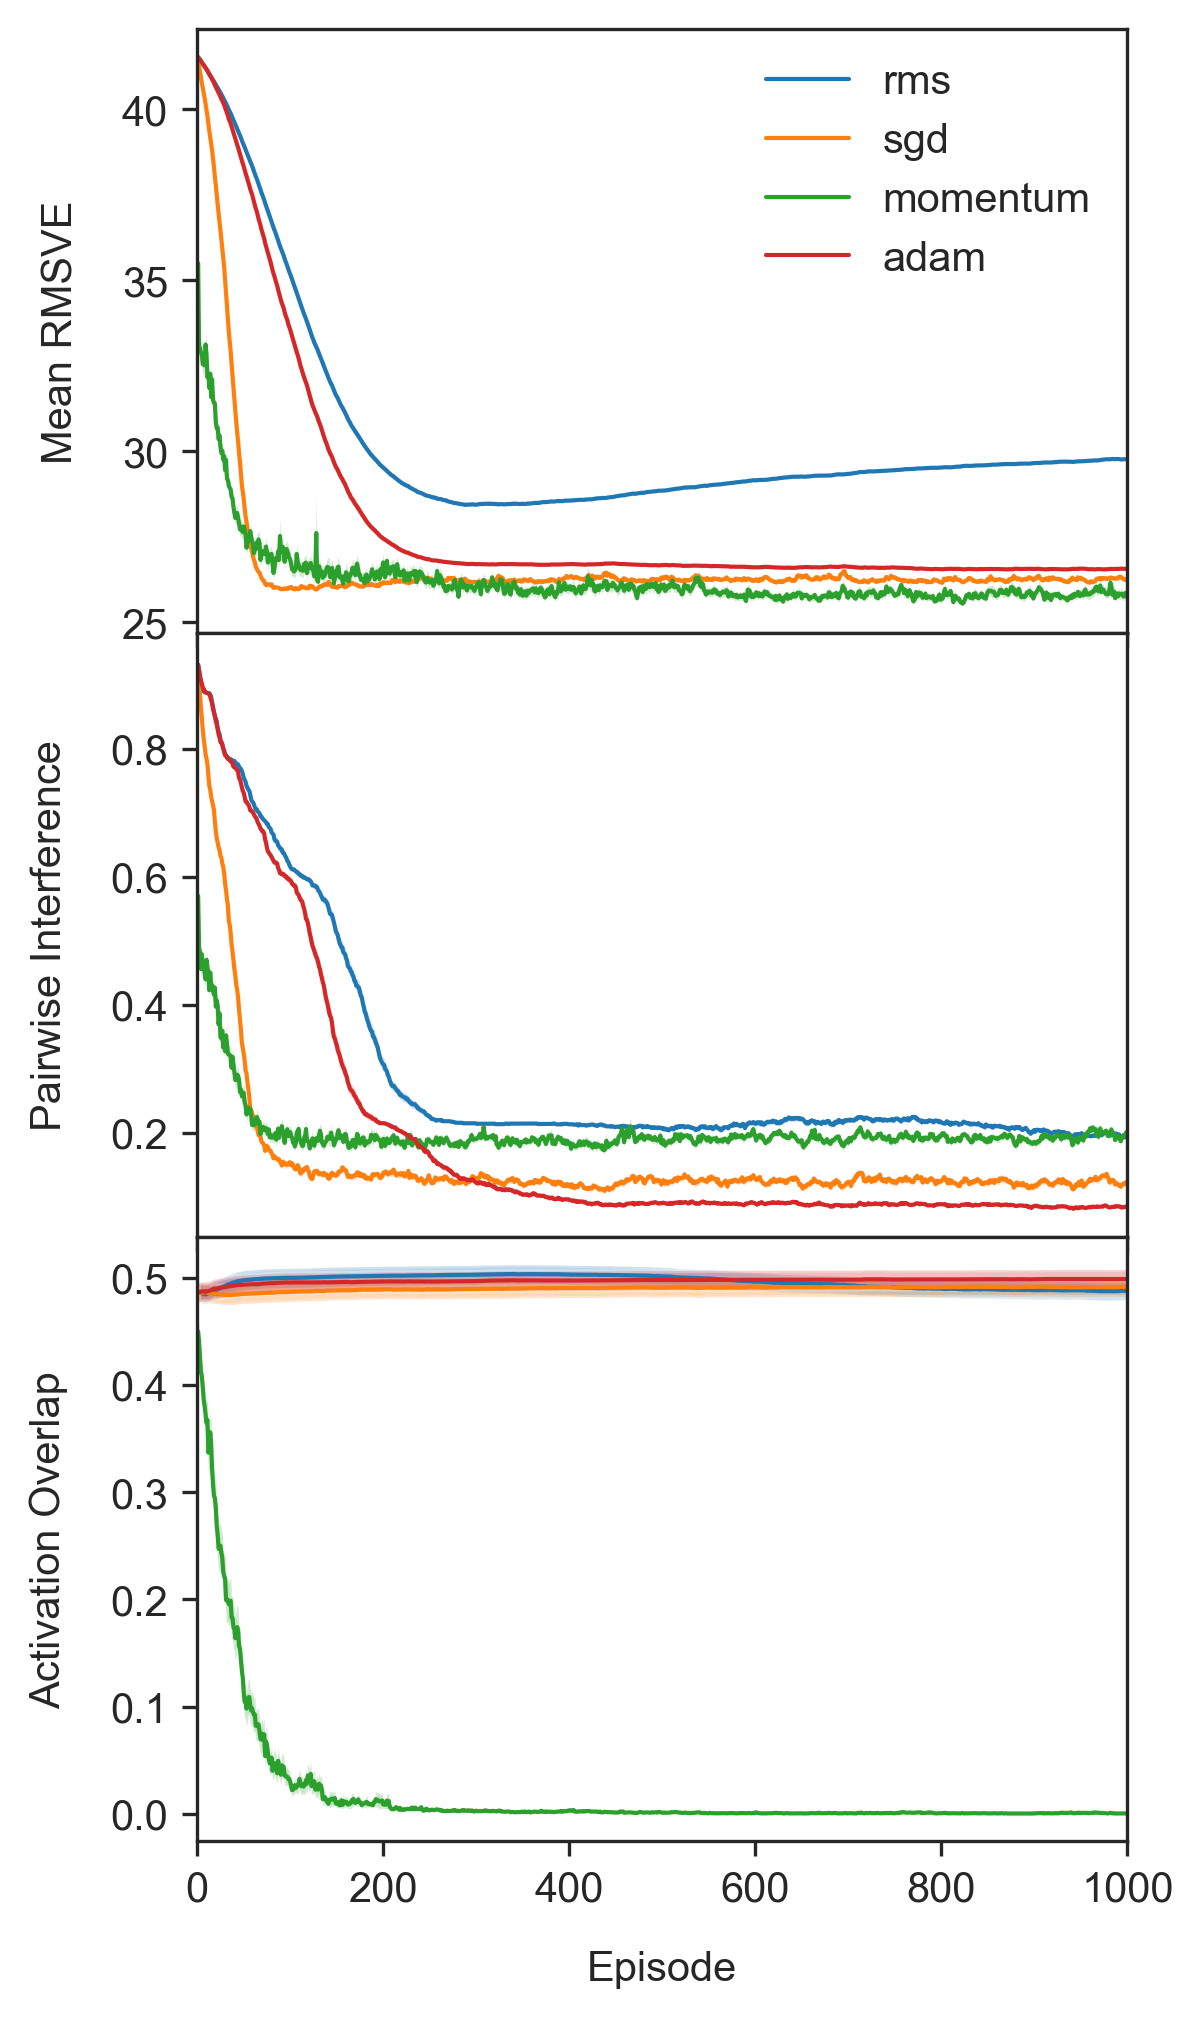

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')
metric = 'pairwise_interference'
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
for optimizer, value in best_by_optimizer_summary.items():
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    y2 = value['pairwise_interference_mean']
    y2err = value['pairwise_interference_stderr']
    y3 = value['activation_overlap_mean']
    y3err = value['activation_overlap_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1)
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3)
    ax2.plot(
        x,
        y2,
        linewidth=1)
    ax2.fill_between(
        x,
        y2 - y2err,
        y2 + y2err,
        alpha=0.3)
    ax3.plot(
        x,
        y3,
        linewidth=1)
    ax3.fill_between(
        x,
        y3 - y3err,
        y3 + y3err,
        alpha=0.3)
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_xlim(0, 1000)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(0.94, 0.83), frameon=False)
fig.subplots_adjust(hspace=0)
fig.savefig('results.png', bbox_inches='tight')